# <center>Diabetic Retinopathy Detection using PyTorch<center>

<img src = 'https://raw.githubusercontent.com/dimitreOliveira/APTOS2019BlindnessDetection/master/Assets/banner.png' >

### What is Diabetic Retinopathy?
Diabetic Retinopathy is a condition that can cause Vision loss and Blindness in the people who have Diabetes. It affects the blood vessels in the Retina. It is one of the leading cause of Blindness across the world. Diabetic retinopathy may not have any symptoms at first, but finding it early can help you take steps to protect your vision. 
### Problem Statement :
The problem is to perform Image Classification. Given an image (fundus photographs), You have to predict which class does the given image belongs to. The Classes to predict are :
*  0 - Normal <br>
*  1 - Mild <br>
*  2 - Moderate <br>
*  3 - Severe <br>
*  4 - Proliferative <br>

<img src = 'https://repository-images.githubusercontent.com/195603342/63983100-b4a6-11e9-846c-99b9465f7b3b'>

## Import Libraries

In [1]:
import pandas as pd #For reading csv files.
import numpy as np 
import matplotlib.pyplot as plt #For plotting.

import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader #For working with data.

from torchvision import models,transforms #For pretrained models,image transformations.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


## EDA

I am using only the data from https://www.kaggle.com/c/aptos2019-blindness-detection/data. If you've more computing resources, you can also use the data from https://www.kaggle.com/c/diabetic-retinopathy-detection/data.

In [3]:
path = "/kaggle/input/aptos2019-blindness-detection/"

train_df = pd.read_csv(f"{path}train.csv")
print(f'No.of.training_samples: {len(train_df)}')

test_df = pd.read_csv(f'{path}test.csv')
print(f'No.of.testing_samples: {len(test_df)}')

No.of.training_samples: 3662
No.of.testing_samples: 1928


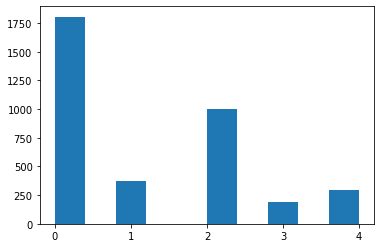

In [4]:
#Histogram of label counts.
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [5]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
 
print(class_weights) #Prints the calculated weights for the classes.

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


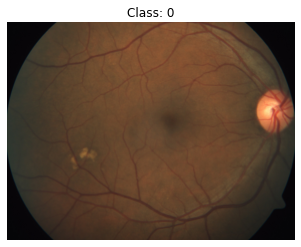

In [6]:
#For getting a random image from our training set.
num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
sample_image = (f'{path}train_images/{train_df["id_code"][num]}.png')#Image file.
sample_image = Image.open(sample_image) 
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_df["diagnosis"][num]}') #Class of the random image.
plt.show()

## Preprocess the Data

In [7]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.
            

In [8]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.
data_set = dataset(train_df,f'{path}train_images',image_transform=image_transform)

#Split the data_set so that valid_set contains 0.1 samples of the data_set. 
train_set,valid_set = torch.utils.data.random_split(data_set,[3302,360])

In [9]:
train_dataloader = DataLoader(train_set,batch_size=32,shuffle=True) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=32,shuffle=False) #DataLoader for validation_set.

## Build the Model

In [10]:
#Since we've less data, we'll use Transfer learning.
model = models.resnet34(pretrained=True) #Downloads the resnet18 model which is pretrained on Imagenet dataset.

#Replace the Final layer of pretrained resnet18 with 4 new layers.
model.fc = nn.Sequential(nn.Linear(512,256),nn.Linear(256,128),nn.Linear(128,64),nn.Linear(64,5))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [11]:
model = model.to(device) #Moves the model to the device.

## Create functions for Training & Validation

In [12]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.
         
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.
    
    total = 0
    correct = 0
    running_loss = 0
    
    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.
        
        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.
       
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        
        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.
             
    
    avg_loss = running_loss/len(dataloader) # Average loss for a single batch
    
    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [13]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): #No need to calculate the gradients.
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    
    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

## Optimize the Model

In [14]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.
    
    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.
        
    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss = train(train_dataloader,model,loss_fn,optimizer) #Calls the train function.
        train_losses.append(train_loss)
        valid_loss = validate(valid_dataloader,model,loss_fn) #Calls the validate function.
        valid_losses.append(valid_loss)
    
    print('\nTraining has completed!')
    
    return train_losses,valid_losses

In [15]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
nb_epochs = 30
#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs)


Epoch 1/30
-------------------------------

Training Loss per batch = 1.617871	Accuracy on Training set = 26.529376% [876/3302]

Validation Loss per batch = 1.600907	Accuracy on Validation set = 27.777778% [100/360]

Epoch 2/30
-------------------------------

Training Loss per batch = 1.585840	Accuracy on Training set = 31.980618% [1056/3302]

Validation Loss per batch = 1.572229	Accuracy on Validation set = 62.222222% [224/360]

Epoch 3/30
-------------------------------

Training Loss per batch = 1.559127	Accuracy on Training set = 62.840703% [2075/3302]

Validation Loss per batch = 1.540123	Accuracy on Validation set = 64.444444% [232/360]

Epoch 4/30
-------------------------------

Training Loss per batch = 1.528845	Accuracy on Training set = 64.082374% [2116/3302]

Validation Loss per batch = 1.505681	Accuracy on Validation set = 68.333333% [246/360]

Epoch 5/30
-------------------------------

Training Loss per batch = 1.494670	Accuracy on Training set = 67.171411% [2218/3302]

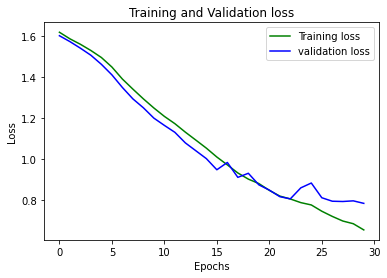

In [16]:
#Plot the graph of train_losses & valid_losses against nb_epochs.
epochs = range(nb_epochs)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing the model

In [17]:
test_set = dataset(test_df,f'{path}test_images',image_transform = image_transform,train = False )

test_dataloader = DataLoader(test_set, batch_size=32, shuffle=False) #DataLoader for test_set.

In [18]:
def test(dataloader,model):
    '''
    test function predicts the labels given an image batches.
    
    Args :
         dataloader: DataLoader for the test_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         
    Returns :
         List of predicted labels.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    labels = [] #List to store the predicted labels.
    
    with torch.no_grad():
        
        for batch,x in enumerate(dataloader):
            
            output = model(x.to(device))
            
            predictions = output.argmax(dim=1).cpu().detach().tolist() #Predicted labels for an image batch.
            labels.extend(predictions)
                
    print('Testing has completed')
            
    return labels                

In [19]:
labels = test(test_dataloader,model) #Calls the test function.

Testing has completed


We can able to increase the accuracy of the model by various ways, like increasing the dataset size, increasing the model complexity, using ensemble models, and increasing the number of epochs.